# 1.线性回归
+ 回归（regression）是能为⼀个或多个⾃变量与因变量之间关系建模的⼀类⽅法。在⾃然科学和社会科学领域，回归经常⽤来表⽰输⼊和输出之间的关系。
+ 我们可以将线性回归模型视为仅由单个⼈⼯神经元组成的神经⽹络，或称为单层神经⽹络。


## 从零开始实现

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [2]:
# 生成数据集
def synthetic_data(w, b, num_examples): #@save
    # 生成y=Xw+b噪声
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape) # 对y的结果加上方差为0.01，均值为0的噪声
    return X, y.reshape((-1, 1)) # 这里的reshape是将数据转为1列

In [4]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print('features: ', features[0], '\nlabels: ', labels[0])

features:  tensor([-1.0754, -0.0419]) 
labels:  tensor([2.1809])


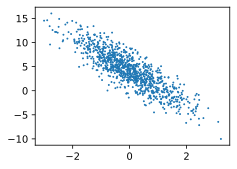

In [6]:
# 生成特征与结果之间的散点图关系
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

In [7]:
# 读取数据集
def data_iter(batch_size, features, labels):
    num_examples = len(features) # 样本数
    indices = list(range(num_examples)) # 标签集合
    random.shuffle(indices) # 随机打乱下标
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(num_examples, i+batch_size)]
        )
        yield features[batch_indices], labels[batch_indices]
        # 返回打乱后的批量样本        

In [8]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break # 打印获取的数据

tensor([[-1.5456,  0.1117],
        [-0.2729,  1.1693],
        [-0.4862,  0.0761],
        [-1.2523, -0.7558],
        [-0.7931,  1.7904],
        [ 1.0290, -1.1158],
        [ 1.1399, -1.5002],
        [-0.8417,  0.0619],
        [-0.3214,  1.7539],
        [ 0.8228, -1.6400]]) 
 tensor([[ 0.7422],
        [-0.3260],
        [ 2.9613],
        [ 4.2618],
        [-3.4795],
        [10.0348],
        [11.5774],
        [ 2.3029],
        [-2.4062],
        [11.4178]])


In [9]:
# 初始化模型参数
# tensor有一个requires_grad参数，如果设置为True，则反向传播时，该tensor就会自动求导。
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [10]:
# 定义模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [11]:
# 定义损失函数，这里采用均方误差损失
def squared_loss(y_hat, y): #@save
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [12]:
# 定义优化算法
def sgd(params, lr, batch_size):
    #torch.no_grad()在该模块下，所有计算得出的tensor的requires_grad都自动设置为False
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [14]:
# 训练
lr = 0.03
net = linreg
num_epochs = 3
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # 计算模型预测值与真实值之间的差距
        l.sum().backward() # 反向传播计算梯度
        sgd([w, b], lr, batch_size) # 更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        

epoch 1, loss 0.034856
epoch 2, loss 0.000127
epoch 3, loss 0.000050


## 简洁实现

In [18]:
# 生成数据集
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [19]:
# 读取数据集
def load_array(data_arrays, batch_size, is_train=True): #@save
    # 构建一个PyTroch数据迭代器
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)


In [20]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [21]:
next(iter(data_iter))

[tensor([[-0.0841, -0.1776],
         [ 1.7637, -0.1939],
         [-0.6513,  0.1214],
         [ 0.2055, -0.6300],
         [ 1.2508,  0.5653],
         [-0.4789, -0.2620],
         [ 1.2650,  1.2300],
         [-0.3562,  0.0125],
         [-0.2477, -1.0944],
         [ 0.8838,  0.1231]]),
 tensor([[4.6318],
         [8.4004],
         [2.4798],
         [6.7663],
         [4.7658],
         [4.1410],
         [2.5533],
         [3.4423],
         [7.3982],
         [5.5526]])]

In [22]:
# 定义模型
from torch import nn

net = nn.Sequential(nn.Linear(2,1)) 

In [23]:
# 初始化模型参数
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [24]:
# 定义损失函数
loss = nn.MSELoss()

In [25]:
# 定义优化算法
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [26]:
# 训练
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad() # 梯度清零
        l.backward() # 反向传播计算梯度
        trainer.step() # 更新参数
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000172
epoch 2, loss 0.000092
epoch 3, loss 0.000092


In [28]:
w = net[0].weight.data
print('w的估计误差: ', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差: ', true_b - b)

w的估计误差:  tensor([-1.8358e-05,  1.8525e-04])
b的估计误差:  tensor([8.8692e-05])
